# Solve Sokoban with Deep Reinforcements Learning
---

<br><br>
<img src="https://play-lh.googleusercontent.com/e_oKlKPISbgdzut1H9opevS7-LTB8-8lsmpCdMkhlnqFenZhpjxbLmx7l158-xQQCIY">

### https://github.com/mpSchrader/gym-sokoban

# Installs

In [ ]:
%%capture
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install gym
!pip install pygame
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install gym_sokoban
!git clone https://github.com/avivg7/sokoban-so.git
!unzip /content/sokoban-so/Compress.zip

# Imports

In [ ]:
import numpy as np
import gym
from gym import logger as gymlogger
from gym.utils import seeding
from gym import error, spaces, utils
gymlogger.set_level(40) # error only
from soko_pap import *
import glob
import io
import base64
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pygame
import pyvirtualdisplay
import imageio
import IPython
import time
import copy
import torch
from tqdm import tqdm
import torch.nn as nn
from torch.optim import SGD
from collections import namedtuple, deque

# Display utils
The cell below contains the video display configuration. No need to make changes here.

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
REPLAY_MEMORY_SIZE = 10000

# Deep Q-Learning Algorithm

### QNN-Model
Define the DNN which approximates the Q-function:

In [ ]:
class QNN(nn.Module):
  "DNN to approximate the Q-function"
  def __init__(self):
    super(QNN, self).__init__()
    self.model = torch.nn.Sequential(
      torch.nn.Conv2d(3, 32, 5),
      torch.nn.MaxPool2d((2,2)),
      torch.nn.ReLU(),
      torch.nn.Conv2d(32,64, 5),
      torch.nn.MaxPool2d((2,2)),
      torch.nn.ReLU(),
      torch.nn.Conv2d(64,128, 5),
      torch.nn.MaxPool2d((2,2)),
      torch.nn.ReLU(),
      torch.nn.Flatten(),
      torch.nn.Linear(12800, 512),
      torch.nn.ReLU(),
      torch.nn.Linear(512, 13))

  def forward(self, x):
    return self.model(x)


### Replay Memory
Define the replay memory buffer which stores past experiences to reduce the correlation between successive updates and to improve stability.

In [ ]:
class ReplayMemory(object):
  "stores past experiences as fifo"
  def __init__(self, capacity, batch_size):
    self.batch_size = batch_size
    self.memory_baffer = deque([], maxlen=capacity)
    self.transition = namedtuple('T', ('s', 'a', 'ns', 'r'))

  def __len__(self):
        return len(self.memory_baffer)

  def push(self, state, action, next_state, reward):
    transition = (state, action, next_state, reward)
    self.memory_baffer.append(transition)

  def sample(self):
    batch = random.sample(self.memory_baffer, self.batch_size)
    return self.transition(*zip(*batch))


### DQN - Deep Q-Network Algorithm
Define the algorithm of Deep Q-Learning using DNN

In [ ]:
class DQN():

  def __init__(self, env, epsilon, decay_rate, discount_factor, change_reward=True):
    self.original_env = env
    self.epsilon = epsilon
    self.decay = decay_rate
    self.discount_factor = discount_factor
    self.change_reward = change_reward
    self.policy = QNN().to(device)
    self.target = QNN().to(device)
    self.buffer= ReplayMemory(REPLAY_MEMORY_SIZE, BATCH_SIZE)
    self.optimizer = SGD(self.policy.parameters(), lr=0.0001)
    self.update_target(self.target)

  def update_target(self, target):
    target.load_state_dict(self.policy.state_dict())

  def get_state_tensor(self, state, done=False):
    if done:
      return None
    return torch.tensor(state, device=device, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)

  def update_epsilon(self):
    self.epsilon *= self.decay
    if self.epsilon < 0.05:
      self.epsilon = 0.05

  def epsilon_greedy_action(self, state):
    if random.random() < self.epsilon:
      return torch.tensor([[self.env.action_space.sample()]], device=device, dtype=torch.long)
    else:
      with torch.no_grad():
        return self.policy(state).max(1)[1].view(1, 1)

  def calculate_reward(self):
    reward = 0
    if self.change_reward:
      room_state = self.env.room_state
      room_fixed = self.env.room_fixed
      box_x, box_y= np.where(room_state == 4)
      target_x, target_y = np.where(room_fixed == 2)
      for i in range(len(box_x)):
        for j in range(len(target_x)):
          # Calculate distance between a box and a target
          reward -= abs(box_x[i] - target_x[j]) + abs(box_y[i] - target_y[j])
    return float(reward)

  def update_model(self):
    "The heart of DQN Algorithm"
    batch = self.buffer.sample()
    state_batch = torch.cat(batch.s)
    action_batch = torch.cat(batch.a)
    reward_batch = torch.cat(batch.r)
    next_state_batch = torch.cat([ns for ns in batch.ns if ns is not None])
    non_final_mask = torch.tensor(tuple(map(lambda ns: ns is not None, batch.ns)), device=device, dtype=torch.bool)

    # Compute Q-values for the current state and selected actions
    q_values = self.policy(state_batch).gather(1, action_batch)

    # Compute the maximum Q-values for the next states
    # use target network to estimate these Q-values to avoid biasing
    # the estimates with the values produced by the policy network
    next_q_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
      next_q_values[non_final_mask] = self.target(next_state_batch).max(1)[0]

    # Compute the target Q-values
    target_q_values = (next_q_values * self.discount_factor) + reward_batch

    # Compute MSE Loss between predicted and target Q-values
    criterion = torch.nn.MSELoss()
    loss = criterion(q_values, target_q_values.unsqueeze(1))

    # Optimize the model
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    return loss.item()

  def train(self, num_episodes):
    losses, rewards = [], []
    for i in tqdm(range(num_episodes)):
      self.env = copy.deepcopy(self.original_env)
      state = self.get_state_tensor(self.env.get_image(mode='rgb_array'))
      done = False
      episode_reward = 0
      episode_loss = 0
      num_steps = 0
      while not done:
        action = self.epsilon_greedy_action(state)
        self.update_epsilon()
        next_state, reward, done, _ = self.env.step(action.item())
        next_state = self.get_state_tensor(next_state, done)
        reward += self.calculate_reward()
        episode_reward += reward
        reward = torch.tensor([reward], device=device)
        self.buffer.push(state, action, next_state, reward)
        state = next_state
        if len(self.buffer) >= BATCH_SIZE:
          loss = self.update_model()
          episode_loss += loss
          num_steps += 1

      rewards.append(episode_reward)
      losses.append(episode_loss / num_steps)

      # Once in 10 episodes - update target network
      if i % 10 == 9:
        self.update_target(self.target)

      # save the MidWay parameters to show
      if num_episodes / 2 == i:
        self.MidWay = QNN().to(device)
        self.update_target(self.MidWay)

    return losses, rewards

  def test(self, fname, MidWay=False):
    env = copy.deepcopy(self.original_env)
    done = False
    iter = 0
    state = env.get_image(mode='rgb_array')
    video_filename = fname + '.mp4'
    policy = self.policy if MidWay == False else self.MidWay
    with imageio.get_writer(video_filename, fps=10) as video:
      video.append_data(env.render(mode='rgb_array'))
      while (iter < 10) or not done:
        action = policy(self.get_state_tensor(state)).max(1)[1].view(1, 1)
        act = np.array(action.cpu())[0][0]
        state, reward, done, info = env.step(act)
        iter += 1
        video.append_data(env.render(mode='rgb_array'))


# Solve Fix Scenario - One Box

### Explore the parameters
Explore to find the best parameters for solving the environment as fast as possible:

Explore the convergence of the algorithm with and without the reward addition we induced:

100%|██████████| 100/100 [12:27<00:00,  7.47s/it]


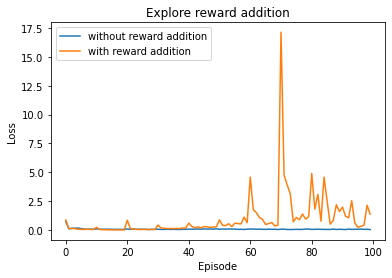

In [ ]:
for i in range(2):
  random.seed(2)
  sok = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=1 ,max_steps=500)
  if 0 == i:
    dqn = DQN(sok, 1.0, 0.999, 0.999, change_reward=False)
    train_losses, train_rewards = dqn.train(100)
    plt.plot(range(len(train_losses)), train_losses, label=f"without reward addition")
  else:
    dqn = DQN(sok, 1.0, 0.999, 0.999, change_reward=True)
    train_losses, train_rewards = dqn.train(100)
    plt.plot(range(len(train_losses)), train_losses, label=f"with reward addition")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.title("Explore reward addition")
plt.legend()
plt.show()

Explore epsilon parameter:

0.7


100%|██████████| 100/100 [13:44<00:00,  8.24s/it]


0.9


100%|██████████| 100/100 [11:23<00:00,  6.84s/it]


1.0


100%|██████████| 100/100 [06:09<00:00,  3.70s/it]


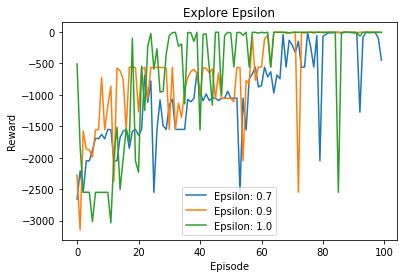

In [ ]:
for eps in [0.7, 0.9, 1.0]:
  print(eps)
  random.seed(2)
  sok = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=1 ,max_steps=500)
  dqn = DQN(sok, eps, 0.999, 0.999)
  train_losses, train_rewards = dqn.train(100)
  plt.plot(range(len(train_rewards)), train_rewards, label=f"Epsilon: {eps}")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Explore Epsilon")
plt.legend()
plt.show()

Explore decay parameter:

100%|██████████| 100/100 [11:15<00:00,  6.75s/it]


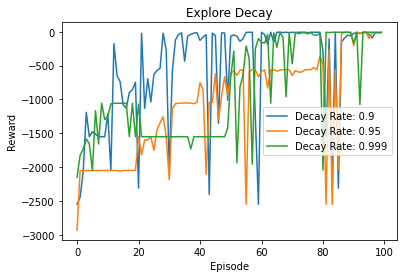

In [ ]:
for decay in [0.9, 0.95, 0.999]:
  random.seed(2)
  sok = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=1 ,max_steps=500)
  dqn = DQN(sok, 1.0, decay, 0.999)
  train_losses, train_rewards = dqn.train(100)
  plt.plot(range(len(train_rewards)), train_rewards, label=f"Decay Rate: {decay}")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Explore Decay")
plt.legend()
plt.show()

Explore Discount factor:

100%|██████████| 100/100 [06:45<00:00,  4.06s/it]


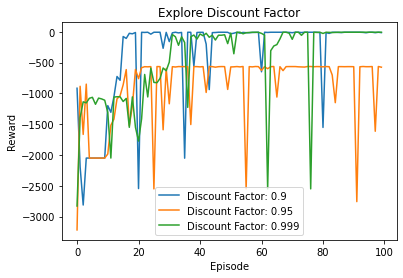

In [ ]:
for df in [0.9, 0.95, 0.999]:
  random.seed(2)
  sok = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=1 ,max_steps=500)
  dqn = DQN(sok, 1.0, 0.999, df)
  train_losses, train_rewards = dqn.train(100)
  plt.plot(range(len(train_rewards)), train_rewards, label=f"Discount Factor: {df}")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Explore Discount Factor")
plt.legend()
plt.show()

###  Solve and display Fix Scenrio - One Box

In [ ]:
random.seed(2)
sok = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=1 ,max_steps=500)

In [ ]:
dqn = DQN(sok, 1, 0.999, 0.999)
train_losses, train_rewards = dqn.train(100)

100%|██████████| 100/100 [08:49<00:00,  5.29s/it]


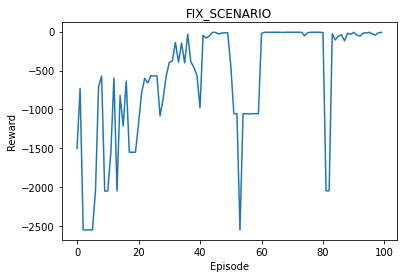

100
[-1500.9999999999964, -730.0000000000083, -2549.999999999976, -2549.999999999976, -2549.999999999976, -2549.999999999976, -2049.9999999999814, -710.0000000000088, -572.0000000000056, -2049.9999999999814, -2049.9999999999814, -1550.9999999999898, -596.0000000000061, -2049.9999999999814, -821.0000000000091, -1213.9999999999898, -636.000000000007, -1550.9999999999898, -1550.9999999999898, -1550.9999999999898, -1185.9999999999927, -788.0000000000091, -600.0000000000061, -660.0000000000075, -567.0000000000055, -571.0000000000056, -568.0000000000053, -1085.0000000000052, -863.0000000000074, -572.0000000000056, -397.20000000000226, -375.0000000000018, -138.99999999999974, -391.2000000000021, -146.49999999999957, -402.1000000000023, -31.900000000000034, -387.400000000002, -460.0000000000035, -560.0000000000053, -979.9000000000052, -47.90000000000004, -82.5999999999999, -57.90000000000001, -10.000000000000002, -10.100000000000003, -29.900000000000027, -20.000000000000014, -14.30000000000000

In [ ]:
plt.plot(range(len(train_rewards)), train_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("FIX_SCENARIO")
plt.show()
print(len(train_rewards))
print(train_rewards)

In [ ]:
dqn.test("FIX_SCENARIO_MidWay", True)
embed_mp4("FIX_SCENARIO_MidWay.mp4")

In [ ]:
dqn.test("FIX_SCENARIO")
embed_mp4("FIX_SCENARIO.mp4")

## Random Scenario - One Box

In [ ]:
sok_2 = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=1 ,max_steps=500)

### Solve and display

In [ ]:
MODEL_PATH2 = "/content/drive/My Drive/dqn_sokoban_model2.pth" # del
dqn_2 = DQN(sok_2, 1, 0.999, 0.999)
train_losses, train_rewards = dqn_2.train(100)

100%|██████████| 100/100 [04:20<00:00,  2.60s/it]


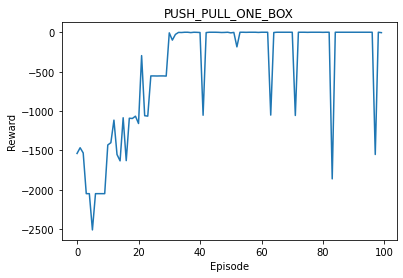

100
[-1538.9999999999895, -1465.9999999999861, -1531.999999999991, -2049.9999999999814, -2049.9999999999814, -2510.999999999977, -2049.9999999999814, -2049.9999999999814, -2049.9999999999814, -2049.9999999999814, -1430.9999999999877, -1401.9999999999889, -1115.0000000000039, -1551.9999999999898, -1632.9999999999873, -1085.000000000005, -1629.9999999999875, -1091.000000000005, -1094.0000000000048, -1065.0000000000061, -1158.0000000000018, -294.6000000000001, -1059.0000000000064, -1064.000000000006, -553.0000000000051, -553.0000000000051, -554.0000000000052, -553.0000000000051, -553.0000000000051, -555.0000000000052, -5.299999999999999, -97.69999999999982, -25.100000000000023, 0.20000000000000107, -0.8999999999999986, 2.4000000000000004, 2.4000000000000004, -1.9999999999999982, 2.4000000000000004, 1.3000000000000007, -0.8999999999999986, -1053.0000000000066, -1.8999999999999986, 2.4000000000000004, 2.4000000000000004, 2.4000000000000004, 1.3000000000000007, -0.8999999999999986, 0.2000000

In [ ]:
plt.plot(range(len(train_rewards)), train_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("PUSH_PULL_ONE_BOX")
plt.show()
print(len(train_rewards))
print(train_rewards)

In [ ]:
dqn_2.test("PUSH_PULL_ONE_BOX_MidWay", True)
embed_mp4("PUSH_PULL_ONE_BOX_MidWay.mp4")

In [ ]:
dqn_2.test("PUSH_PULL_ONE_BOX")
embed_mp4("PUSH_PULL_ONE_BOX.mp4")

## Random Scenario - Two Boxes

In [ ]:
sok_3 = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=2 ,max_steps=500)

### Solve and Display

In [ ]:
dqn_3 = DQN(sok_3, 1, 0.999, 0.999)
train_losses, train_rewards = dqn_3.train(100)

  1%|          | 1/100 [00:09<16:21,  9.91s/it]

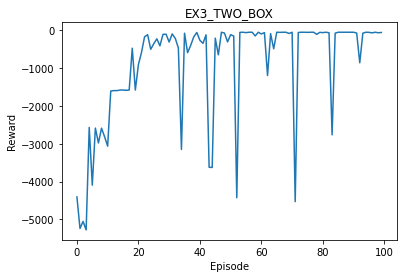

100
[-4403.99999999998, -5237.00000000002, -5052.000000000008, -5276.000000000018, -2568.999999999976, -4093.9999999999677, -2585.9999999999754, -2978.9999999999673, -2588.9999999999754, -2813.999999999971, -3063.9999999999723, -1607.9999999999882, -1594.9999999999884, -1596.9999999999884, -1580.9999999999889, -1580.9999999999889, -1587.9999999999889, -1580.9999999999889, -475.8000000000014, -1580.9999999999889, -910.0000000000026, -590.2000000000018, -175.0999999999998, -119.2999999999999, -503.7000000000015, -357.60000000000053, -227.7999999999997, -412.9000000000011, -109.9999999999999, -106.8999999999999, -313.0000000000002, -98.99999999999991, -217.6999999999998, -469.60000000000133, -3148.6999999999757, -79.89999999999995, -593.6000000000022, -402.00000000000085, -177.09999999999977, -60.4, -267.3, -348.00000000000057, -122.6999999999999, -3620.999999999969, -3626.2999999999706, -210.09999999999982, -650.8000000000017, -54.20000000000001, -76.39999999999996, -309.20000000000016, 

In [ ]:
plt.plot(range(len(train_rewards)), train_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("EX3_TWO_BOX")
plt.show()
print(len(train_rewards))
print(train_rewards)

In [ ]:
dqn_3.test("EX3_TWO_BOX_MidWay", True)
embed_mp4("EX3_TWO_BOX_MidWay.mp4")

In [ ]:
dqn_3.test("EX3_TWO_BOX")
embed_mp4("EX3_TWO_BOX.mp4")